In [4]:
import os
import random
from itertools import combinations
import glob

def create_pairs(fingerprint_dir, num_neg_pairs=2):
    identity_dict = {}
    for img_path in glob.glob(os.path.join(fingerprint_dir, "*.tif")):
        filename = os.path.basename(img_path)
        identity = filename.split("_")[0] 

        if identity not in identity_dict:
            identity_dict[identity] = []
        identity_dict[identity].append(img_path)

    pairs = []
    labels = []

    for identity, images in identity_dict.items():
        for img1, img2 in combinations(images, 2): 
            pairs.append((img1, img2))
            labels.append(1) 
    all_ids = list(identity_dict.keys())
    for _ in range(len(pairs) * num_neg_pairs):
        id1, id2 = random.sample(all_ids, 2)
        img1 = random.choice(identity_dict[id1])
        img2 = random.choice(identity_dict[id2])
        
        pairs.append((img1, img2))
        labels.append(0) 

    return pairs, labels
fingerprint_dir = "/kaggle/input/fvc2004-subset1"
pairs, labels = create_pairs(fingerprint_dir)
print(f"Generated {len(pairs)} pairs")


Generated 840 pairs


In [5]:
import torchvision.transforms as transforms
import torch
from PIL import Image
default_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((480, 480)),
    transforms.RandomRotation(degrees=5),  
    transforms.CenterCrop(450), 
    transforms.RandomAdjustSharpness(sharpness_factor=2), 
    transforms.RandomAutocontrast(),
    transforms.RandomInvert(p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class FingerprintDataset(torch.utils.data.Dataset):
    def __init__(self, image_pairs, labels, transform=None):
        self.image_pairs = image_pairs 
        self.labels = labels 
        self.transform = transform if transform else default_transform  

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1 = Image.open(self.image_pairs[idx][0])
        img2 = Image.open(self.image_pairs[idx][1])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

dataset = FingerprintDataset(pairs, labels)
img1, img2, label = dataset[0]
print(f"Label: {label}")



Label: 1.0


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for img1, img2, label in train_loader:
    print(img1.shape, img2.shape, label.shape) 
    break


torch.Size([32, 1, 450, 450]) torch.Size([32, 1, 450, 450]) torch.Size([32])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [8]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        se = F.adaptive_avg_pool2d(x, 1)
        se = F.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se))
        return x * se 
class MBConv1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, se=True):
        super(MBConv1, self).__init__()
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride, kernel_size // 2, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.se = SEBlock(out_channels) if se else nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        if self.use_residual:
            out += x
        return out
class MBConv6(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, expansion=6, se=True):
        super(MBConv6, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = (stride == 1 and in_channels == out_channels)

        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish()
        ) if expansion > 1 else nn.Identity()

        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish()
        )

        self.se = SEBlock(hidden_dim) if se else nn.Identity() 

        self.pointwise = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.se(out) 
        out = self.pointwise(out)

        if self.use_residual:
            out += x 
        return out



In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

In [10]:
class FingerprintBackbone(nn.Module):
    def __init__(self):
        super(FingerprintBackbone, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            Swish()
        )
        self.blocks = nn.Sequential(
            MBConv1(32, 16, 3, 1),
            MBConv6(16, 24, 3, 2), 
            MBConv6(24, 24, 3, 1), 
            MBConv6(24, 40, 5, 2),
            MBConv6(40, 40, 5, 1), 
            MBConv6(40, 80, 3, 2),
            MBConv6(80, 80, 3, 1),
            MBConv6(80, 80, 3, 1),
            MBConv6(80, 112, 5, 1),
            MBConv6(112, 112, 5, 1),
            MBConv6(112, 112, 5, 1),
            MBConv6(112, 192, 5, 2),
            MBConv6(192, 192, 5, 1),
            MBConv6(192, 192, 5, 1),
            MBConv6(192, 192, 5, 1),
            MBConv6(192, 320, 3, 1), 
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(320, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            Swish()
        )
        self.pooling = nn.AdaptiveAvgPool2d(1) 
        self.flatten = nn.Flatten() 

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.final_conv(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = F.normalize(x, p=2, dim=1) 
        return x

backbone= FingerprintBackbone()

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, backbone):
        super(SiameseNetwork, self).__init__()
        self.backbone = backbone

    def forward(self, img1, img2):
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)
        return feat1, feat2

siamese_net = SiameseNetwork(FingerprintBackbone())

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, feat1, feat2, label):
        euclidean_distance = torch.norm(feat1 - feat2, p=2, dim=1) 
        loss_same = (1 - label) * 0.5 * torch.pow(euclidean_distance, 2) 
        loss_diff = label * 0.5 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2) 
        loss = loss_same + loss_diff
        return loss.mean()

        pos_dist = torch.norm(anchor - positive, p=2, dim=1)
        neg_dist = torch.norm(anchor - negative, p=2, dim=1)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return loss.mean()


In [13]:
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model = SiameseNetwork(FingerprintBackbone()).cuda()
criterion = ContrastiveLoss(margin=1.0).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 25
threshold = 0.1
best_accuracy = 0.0  
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

        feat1, feat2 = model(img1, img2)
        loss = criterion(feat1, feat2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")
    if (epoch + 1) % 5 == 0:
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

                feat1, feat2 = model(img1, img2)
                distances = F.pairwise_distance(feat1, feat2)
                predictions = (distances < threshold).float()

                correct += (predictions == label).sum().item()
                total += label.size(0)

        accuracy = correct / total * 100
        print(f"Validation Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")


print(best_accuracy)
  

Epoch [1/25], Loss: 0.1264
Epoch [2/25], Loss: 0.1217
Epoch [3/25], Loss: 0.1225
Epoch [4/25], Loss: 0.1215
Epoch [5/25], Loss: 0.1221
Validation Accuracy after Epoch 5: 66.07%
Epoch [6/25], Loss: 0.1199
Epoch [7/25], Loss: 0.1177
Epoch [8/25], Loss: 0.1151
Epoch [9/25], Loss: 0.1142
Epoch [10/25], Loss: 0.1153
Validation Accuracy after Epoch 10: 69.05%
Epoch [11/25], Loss: 0.1140
Epoch [12/25], Loss: 0.1142
Epoch [13/25], Loss: 0.1140
Epoch [14/25], Loss: 0.1118
Epoch [15/25], Loss: 0.1121
Validation Accuracy after Epoch 15: 67.86%
Epoch [16/25], Loss: 0.1137
Epoch [17/25], Loss: 0.1113
Epoch [18/25], Loss: 0.1114
Epoch [19/25], Loss: 0.1108
Epoch [20/25], Loss: 0.1130
Validation Accuracy after Epoch 20: 69.05%
Epoch [21/25], Loss: 0.1112
Epoch [22/25], Loss: 0.1129
Epoch [23/25], Loss: 0.1142
Epoch [24/25], Loss: 0.1139
Epoch [25/25], Loss: 0.1135
Validation Accuracy after Epoch 25: 69.05%
Training complete. Best accuracy: 0.0


In [14]:
torch.save(model.state_dict(), "model.pth")

<ipython-input-15-899e444f7c95>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Distance: 0.2747
❌ Different person (Forgery)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


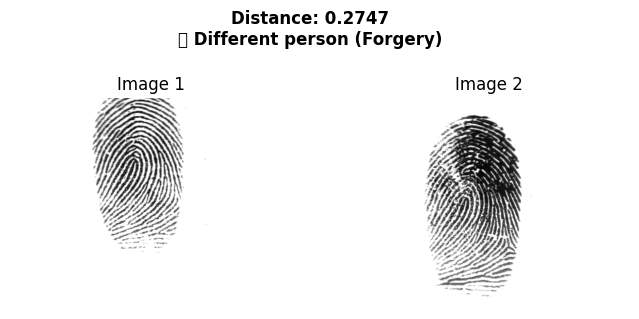

In [15]:
import matplotlib.pyplot as plt
from PIL import Image, TiffImagePlugin
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
best_threshold = 0.1 

def infer_signature(img1_path, img2_path):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((360, 360)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    model.load_state_dict(torch.load("model.pth"))
    model.eval()
    def load_tif_image(path):
        img = Image.open(path)
        if isinstance(img, TiffImagePlugin.TiffImageFile):
            img.seek(0)
        if img.mode not in ["L", "I;16", "F"]:
            img = img.convert("L") 

        return img, transform(img).unsqueeze(0).cuda()

    img1_raw, img1 = load_tif_image(img1_path)
    img2_raw, img2 = load_tif_image(img2_path)
    with torch.no_grad():
        feat1, feat2 = model(img1, img2)
        distance = F.pairwise_distance(feat1, feat2).item()

    print(f"Distance: {distance:.4f}")
    if distance < best_threshold:
        result_text = "Same person"
    else:
        result_text = "Different person"
    
    print(result_text)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1_raw, cmap="gray")
    axes[0].set_title("Image 1")
    axes[0].axis("off")

    axes[1].imshow(img2_raw, cmap="gray")
    axes[1].set_title("Image 2")
    axes[1].axis("off")

    plt.suptitle(f"Distance: {distance:.4f}\n{result_text}", fontsize=12, fontweight="bold")
    plt.show()

img1_path = "/kaggle/input/fvc2004-subset1/103_1.tif"
img2_path = "/kaggle/input/fvc2004-subset1/103_7.tif"
infer_signature(img1_path, img2_path)
